# Ising model 2D

## Introduction

We use in this Jupyter Notebook the `2D-Ising-Model-Package` python package to check that the basic expected properties of the two-dimensional Ising model are well predicted.
In our simple model, the Ising model deals with an square array of spins that interact with coupling constant $J$ with their nearest neighbours in an external field $h$ with the following hamiltonian:
$$
\mathcal{H}(\{\sigma\}) = - J \sum_{\langle i, j \rangle} \sigma_i \sigma_j - h \sum_i \sigma_i
$$
We decided to look at the behavior of the average magnetization per site and the energy of the system in various regimes.

## Package installation

The package that was used can be found [on GitHub](https://github.com/stephen70/2D-Ising-Model-Package), but the version I use is slightly modified and can be found on [this fork](https://github.com/alexandrejourneaux/2D-Ising-Model-Package). 
The main modifications brought to the code were:

- Addition of `tqdm` progress bars to have an estimate of remaining simulation times when a MC simulation is running.
- `return` added to the simulation function in order to make my own plots.

It was cloned in the virtual machine via ssh. And can be installed thanks to pip by uncommenting and running this line:

In [4]:
#!pip install -e ~/2D-Ising-Model-Package

Let us import the package for later use, as well as a few other useful ones.

In [1]:
import ising2D
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

## Influence of the number of simulation steps

Before running any simulation, we want to estimate the number of Monte Carlo iterations needed to reach equilibrium. To do so, we logarithmically sweep the number of iterations and plot the macroscopic properties of interest versus the number of steps. We then choose a value high enough to be on the plateau.

In [20]:
steps = 10**(0.5 * np.arange(13))
energies = []
magnetizations = []

for ii, num_step in tqdm(enumerate(steps)):
    
    model = ising2D.IsingSquare(50, interactionVal=0, magMoment=1)
    
    model.basicIter(iters=num_step, temp=1, plot=False)
    energies.append(model.totalEnergy())
    magnetizations.append(model.totalMag())

13it [00:44,  3.41s/it]


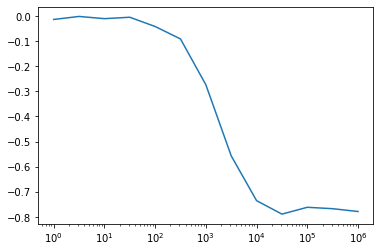

In [21]:
plt.plot(steps, energies)
plt.xscale("log")

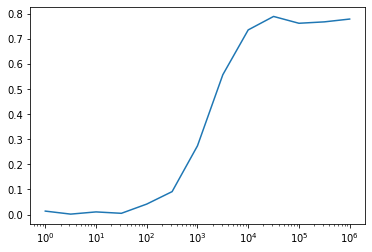

In [22]:
plt.plot(steps, magnetizations)
plt.xscale("log")

It seems that $10^5$ iterations is a reasonable choice for our future simulations.

## Paramagnetic-ferromagnetic transition

We start by qualitatively observing the well-known phase transition between the ferromagnetic and paramagnetic phases at zero magnetic field. The theoretical $T_c$ for a 2-dimensional lattice is at $T_c / J = 2.269$, so we take here $J = 1$. We can see no long-range order on the spin configurations for $T = 4$ and $3$, and it is clear that the up-down symmetry is broken on broader areas for $T=2$ and $T=1$ (where $T$ is expressed in units of $J$).

Here, we used a 100*100 square lattice.

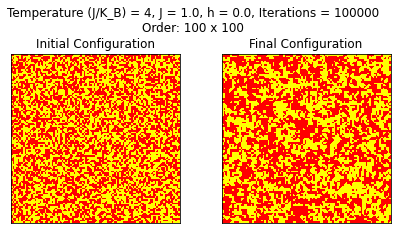

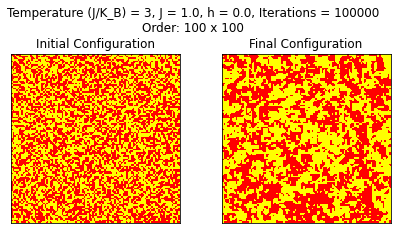

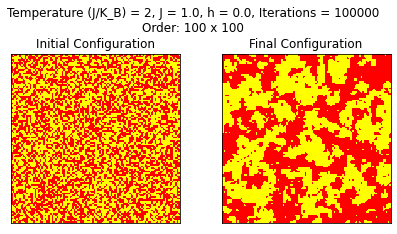

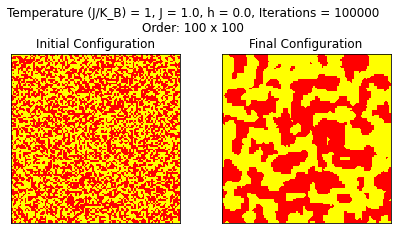

In [7]:
model = ising2D.IsingSquare(100, interactionVal=1, magMoment=0)

for temp in [4, 3, 2, 1]:
    model.basicIter(iters=100000,
                    temp=temp,
                    plot=True)

## No interactions, with various magnetic fields

We can now plot macroscopic quantities of interest, averaged on 1000 Monte Carlo iterations (this value is fixed in the code). Let us start with a very simple case (we can easily solve it analytically) where there are no interactions between the spins, but an non zero applied magnetic field.


In [13]:
N_mag = 3
tempRange = np.linspace(0.1, 8, 50)

magFields = np.linspace(0.5, 1.5, N_mag, endpoint=True)

In [20]:
result_dicts = []

for ii, magField in enumerate(magFields):
    
    model = ising2D.IsingSquare(50, interactionVal=0, magMoment=magField)
    
    result_dicts.append(
        model.tempRangeIter(
            tempRange=tempRange,
            itersPerTemp=1e5,
            plotProperties=False
        )
    )

100%|██████████| 50/50 [23:01<00:00, 27.63s/it]


We can store the results in a csv file for future use by setting the `save_result` flag to `True` and running the following cell.

In [21]:
save_results = False

if save_results:
    for i, d in enumerate(result_dicts):
        df = pd.DataFrame.from_dict(d, orient="index")
        df.to_csv(f"result_dicts_{i}.csv")

If one wishes to reload the previously obtained results, just set the `read_csv` flag to `True` and run the following cell.

In [11]:
read_csv = False
N_mag = 3

if read_csv:
    result_dicts = []
    for i in range(N_mag):
        df = pd.read_csv(f"result_dicts_{i}.csv", index_col=0)
        d = df.to_dict("split")
        result_dicts.append(dict(zip(d["index"], d["data"])))

We can now plot both the magnetization per site and the total energy of the system, and compare them with the analytical predictions. As we can see on the plots below, the relative error does not exceed 8% for the magnetization and 6% for the total energy, and the global tendency is reproduced by the simulation.

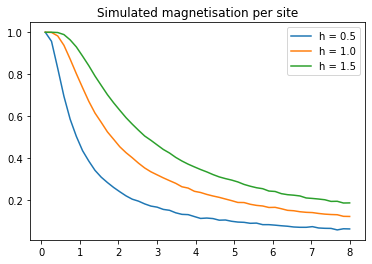

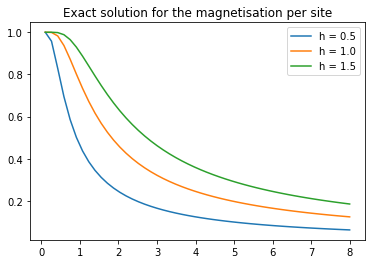

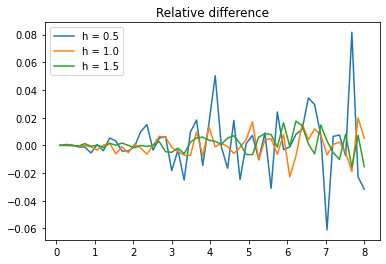

In [18]:
for ii in range(N_mag):
    
    exact = [np.tanh(magFields[ii] / temp) for temp in tempRange]
    
    plt.figure(1)
    plt.plot(result_dicts[ii]["tempRange"], result_dicts[ii]["magList"], label=f"h = {magFields[ii]}")
    plt.title("Simulated magnetisation per site")
    plt.legend()
    
    plt.figure(2)
    plt.plot(tempRange, exact, label=f"h = {magFields[ii]}")
    plt.title("Exact solution for the magnetisation per site")
    plt.legend()
    
    plt.figure(3)
    plt.plot(tempRange, (np.array(exact) - np.array(result_dicts[ii]["magList"])) / np.array(exact), label=f"h = {magFields[ii]}")
    plt.title("Relative difference")
    plt.legend()

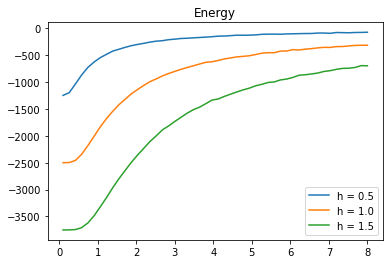

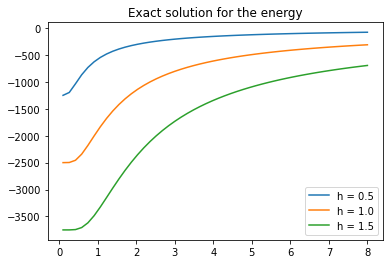

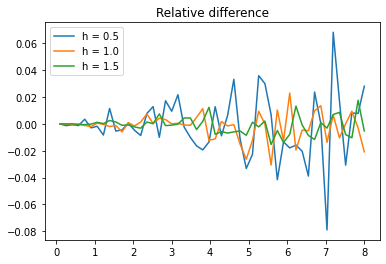

In [22]:
for ii in range(N_mag):
    
    exact = [- model.order**2 * magFields[ii] * np.tanh(magFields[ii] / temp) for temp in tempRange]
    
    plt.figure(1)
    plt.plot(result_dicts[ii]["tempRange"], result_dicts[ii]["energyList"], label=f"h = {magFields[ii]}")
    plt.title("Energy")
    plt.legend()
    
    plt.figure(2)
    plt.plot(tempRange, exact, label=f"h = {magFields[ii]}")
    plt.title("Exact solution for the energy")
    plt.legend()
    
    plt.figure(3)
    plt.plot(tempRange, (np.array(exact) - np.array(result_dicts[ii]["energyList"])) / np.array(exact), label=f"h = {magFields[ii]}")
    plt.title("Relative difference")
    plt.legend()

## No magnetic field, with various interactions

Let's check another case in which we can compare our results with theoretical results: we turn off the magnetic field and turn on the interactions between nearest neighbors. We sweep the value of the interaction to see if the qualitative results are convincing compared to what we know.

In [26]:
N_int = 3
tempRange = np.linspace(0.1, 8, 50)

interactions = np.linspace(0.5, 1.5, N_int, endpoint=True)
result_dicts2 = []

for ii, interaction in enumerate(interactions):
    
    model = ising2D.IsingSquare(50, interactionVal=interaction, magMoment=0)
    
    result_dicts2.append(
        model.tempRangeIter(
            tempRange=tempRange,
            itersPerTemp=1e5,
            plotProperties=False
        )
    )

100%|██████████| 50/50 [22:49<00:00, 27.39s/it]


We can store the results in a csv file for future use by setting the `save_result` flag to `True` and running the following cell.

In [29]:
save_results = False

if save_results:
    for i, d in enumerate(result_dicts2):
        df = pd.DataFrame.from_dict(d, orient="index")
        df.to_csv(f"result_dicts2_{i}.csv")

If one wishes to reload the previously obtained results, just set the `read_csv` flag to `True` and run the following cell.

In [30]:
read_csv = False
N_mag = 3

if read_csv:
    result_dicts2 = []
    for i in range(N_mag):
        df = pd.read_csv(f"result_dicts2_{i}.csv", index_col=0)
        d = df.to_dict("split")
        result_dicts2.append(dict(zip(d["index"], d["data"])))

Again, we can plot the magnetization and the total energy versus the temperature.

As expected, the magnetization is zero above a temperature threshold and a global magnetisation builds up under this critical temperature. The origin of the fluctuations on the plot is unclear, it might be caused by a lack of averaging (the program automatically averages on 10 000 additional iterations after the specified number of steps). However, we recognize the dependency of the critical temperature to decrease with increasing coupling constant $J$. 

Also as expected, the energy is lowered at low temperatures.

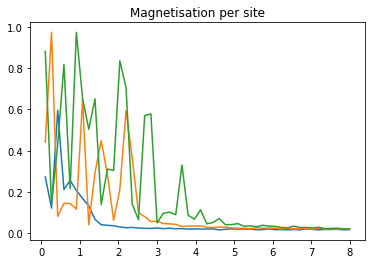

In [31]:
for ii in range(3):
    plt.figure(1)
    plt.plot(result_dicts2[ii]["tempRange"], np.abs(result_dicts2[ii]["magList"]))
    plt.title("Magnetisation per site")

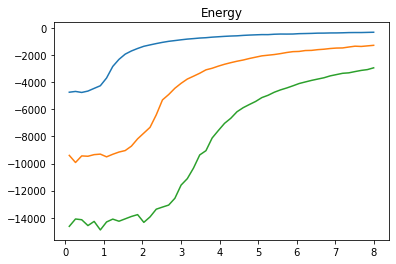

In [32]:
for ii in range(3):
    plt.figure(1)
    plt.plot(result_dicts2[ii]["tempRange"], result_dicts2[ii]["energyList"])
    plt.title("Energy")